In [3]:
%matplotlib inline


Transfer Learning for Computer Vision Tutorial
==============================================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at `cs231n notes <https://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [4]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



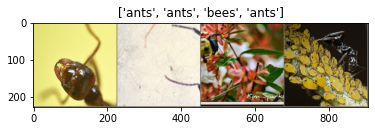

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                
                print(inputs)
                print(labels)
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [13]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [14]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [15]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
tensor([[[[-0.5424, -0.5424, -0.5596,  ...,  0.9646,  0.9817,  0.9474],
          [-0.5424, -0.5596, -0.5596,  ...,  0.9817,  0.9817,  0.9303],
          [-0.5424, -0.5596, -0.5596,  ...,  0.9817,  0.9817,  0.9303],
          ...,
          [ 1.3413,  1.3413,  1.3070,  ...,  1.9235,  2.0092,  2.0948],
          [ 1.3242,  1.3242,  1.2899,  ...,  1.9235,  1.9920,  2.0777],
          [ 1.2899,  1.2728,  1.2385,  ...,  1.9064,  1.9749,  2.0434]],

         [[-0.7402, -0.7402, -0.7577,  ...,  0.6429,  0.6604,  0.6254],
          [-0.7577, -0.7577, -0.7577,  ...,  0.6604,  0.6604,  0.6078],
          [-0.7577, -0.7577, -0.7577,  ...,  0.6604,  0.6604,  0.6078],
          ...,
          [ 1.1155,  1.0980,  1.0630,  ...,  1.8683,  1.9559,  2.0609],
          [ 1.0980,  1.0805,  1.0280,  ...,  1.8508,  1.9384,  2.0434],
          [ 1.0455,  1.0280,  0.9755,  ...,  1.8158,  1.8859,  2.0084]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.7870, -1.8044],
        

tensor([[[[ 0.4851,  0.4851,  0.4679,  ..., -0.3198, -0.5938, -0.6109],
          [ 0.5193,  0.5193,  0.4851,  ..., -0.5767, -1.0048, -1.1760],
          [ 0.4851,  0.4851,  0.4851,  ..., -1.1760, -1.2617, -1.2959],
          ...,
          [-0.8849, -1.0048, -1.1247,  ...,  1.3413,  1.4783,  1.4954],
          [-1.0048, -1.1075, -1.2274,  ...,  1.3755,  1.4612,  1.5125],
          [-1.0048, -1.1075, -1.1589,  ...,  1.4440,  1.4440,  1.4954]],

         [[-0.0224, -0.0224, -0.0399,  ..., -0.5826, -0.8277, -0.8277],
          [ 0.0126,  0.0126, -0.0224,  ..., -0.8452, -1.2479, -1.4055],
          [-0.0049, -0.0049, -0.0049,  ..., -1.4405, -1.4230, -1.4755],
          ...,
          [-1.3004, -1.4230, -1.5280,  ...,  0.8354,  0.9230,  0.9230],
          [-1.4230, -1.5280, -1.6331,  ...,  0.8880,  0.9405,  0.9405],
          [-1.4230, -1.5280, -1.5630,  ...,  0.9580,  0.9230,  0.9230]],

         [[-0.1138, -0.1138, -0.1312,  ..., -0.6018, -0.7587, -0.7238],
          [-0.0790, -0.0790, -

tensor([[[[-0.2856, -0.4054, -0.3541,  ..., -0.7137, -1.1589, -1.4158],
          [-0.4226, -0.4568, -0.3198,  ..., -0.5767, -0.9877, -1.2274],
          [-0.6452, -0.5253, -0.2513,  ..., -0.3541, -0.7308, -0.9363],
          ...,
          [-0.0116, -0.3369, -0.2171,  ..., -1.8953, -1.9295, -1.9809],
          [-0.2856, -0.4568, -0.3541,  ..., -1.9295, -1.9467, -1.9467],
          [-0.4568, -0.5253, -0.4568,  ..., -1.9467, -1.9467, -1.9295]],

         [[-0.1625, -0.2850, -0.2325,  ..., -0.6001, -1.0553, -1.3179],
          [-0.3025, -0.3375, -0.1975,  ..., -0.4601, -0.8803, -1.1253],
          [-0.5301, -0.4076, -0.1275,  ..., -0.2325, -0.6176, -0.8277],
          ...,
          [ 0.1176, -0.2150, -0.0924,  ..., -1.8081, -1.8431, -1.8957],
          [-0.1625, -0.3375, -0.2325,  ..., -1.8431, -1.8606, -1.8606],
          [-0.3375, -0.4076, -0.3375,  ..., -1.8606, -1.8606, -1.8431]],

         [[-0.0790, -0.2010, -0.1487,  ..., -0.3753, -0.8284, -1.0898],
          [-0.2358, -0.2707, -

tensor([[[[ 1.4098,  1.3927,  1.3755,  ...,  1.3070,  1.3242,  1.3242],
          [ 1.4098,  1.3927,  1.3755,  ...,  1.3242,  1.3242,  1.3927],
          [ 1.3927,  1.3927,  1.3755,  ...,  1.3413,  1.3070,  1.3413],
          ...,
          [ 1.3755,  1.3755,  1.3755,  ...,  1.1358,  1.1700,  1.1187],
          [ 1.4098,  1.3755,  1.3755,  ...,  1.0844,  1.1187,  1.1015],
          [ 1.3584,  1.3242,  1.3584,  ...,  1.0502,  1.1015,  1.1358]],

         [[ 1.3431,  1.3606,  1.3431,  ...,  1.1856,  1.2031,  1.2031],
          [ 1.3256,  1.3431,  1.3256,  ...,  1.2031,  1.2381,  1.3256],
          [ 1.3431,  1.3431,  1.3256,  ...,  1.2556,  1.2556,  1.2731],
          ...,
          [ 1.3081,  1.3081,  1.3081,  ...,  0.8880,  0.9405,  0.8880],
          [ 1.3431,  1.3081,  1.3081,  ...,  0.8704,  0.8880,  0.8704],
          [ 1.2906,  1.2556,  1.2906,  ...,  0.8354,  0.8704,  0.9055]],

         [[ 1.2805,  1.2631,  1.2457,  ...,  1.1237,  1.1411,  1.1411],
          [ 1.3154,  1.2805,  

tensor([[[[ 2.1119,  2.0948,  2.0948,  ...,  1.9920,  1.9578,  1.9578],
          [ 2.0948,  2.0948,  2.0948,  ...,  1.9749,  1.9407,  1.9407],
          [ 2.0948,  2.0948,  2.0948,  ...,  1.9578,  1.9749,  1.9749],
          ...,
          [ 1.8893,  1.8550,  1.8379,  ...,  1.8208,  1.8037,  1.7865],
          [ 1.9064,  1.8893,  1.8722,  ...,  1.8037,  1.7865,  1.8037],
          [ 1.8893,  1.8893,  1.8722,  ...,  1.8037,  1.7865,  1.8037]],

         [[ 1.4307,  1.4132,  1.4132,  ...,  1.3256,  1.3256,  1.3256],
          [ 1.4132,  1.4132,  1.4132,  ...,  1.3081,  1.3081,  1.3081],
          [ 1.4307,  1.4307,  1.4307,  ...,  1.2906,  1.3081,  1.3081],
          ...,
          [ 1.2031,  1.1681,  1.1155,  ...,  1.0980,  1.0805,  1.0630],
          [ 1.2381,  1.2031,  1.1506,  ...,  1.0805,  1.0630,  1.0805],
          [ 1.2206,  1.2031,  1.1506,  ...,  1.0805,  1.0630,  1.0805]],

         [[ 1.5594,  1.5071,  1.5071,  ...,  1.5420,  1.5768,  1.5768],
          [ 1.5071,  1.5071,  

tensor([[[[-1.4158, -1.5185, -1.4672,  ..., -1.3302, -1.2788, -1.2617],
          [-1.4500, -1.3473, -1.2788,  ..., -1.0904, -1.3473, -1.5014],
          [-1.2103, -1.2617, -1.3987,  ..., -1.0562, -1.3302, -1.4843],
          ...,
          [-1.2103, -1.1418, -1.2445,  ...,  1.2557,  1.1187,  0.9988],
          [-1.1932, -1.1932, -1.2617,  ...,  1.5982,  1.4612,  1.3413],
          [-1.0733, -1.2274, -1.2959,  ...,  1.3755,  1.2385,  1.1529]],

         [[-0.3901, -0.4601, -0.4076,  ..., -0.4076, -0.3025, -0.2675],
          [-0.3725, -0.2675, -0.1975,  ..., -0.1625, -0.3901, -0.5301],
          [-0.1625, -0.1975, -0.3200,  ..., -0.0924, -0.3375, -0.4776],
          ...,
          [-0.3025, -0.2325, -0.3725,  ...,  1.4482,  1.3606,  1.3256],
          [-0.2675, -0.2500, -0.3550,  ...,  1.7633,  1.6583,  1.6057],
          [-0.0924, -0.2325, -0.3200,  ...,  1.9384,  1.8683,  1.8333]],

         [[-1.2816, -1.3339, -1.2816,  ..., -1.3164, -1.2293, -1.2119],
          [-1.2816, -1.1421, -

tensor([[[[-1.1247,  0.1768,  0.2453,  ..., -1.5014, -1.5185, -1.5870],
          [-0.7650, -0.0629,  0.3481,  ..., -1.5528, -1.5528, -1.6042],
          [-0.3883, -0.4911,  0.3481,  ..., -1.5699, -1.5699, -1.5357],
          ...,
          [ 1.1529,  1.3584,  1.5297,  ...,  1.2214,  1.2385,  1.0159],
          [ 1.2728,  1.4783,  1.5468,  ...,  1.3755,  1.2899,  1.2214],
          [ 1.3070,  1.4783,  1.4783,  ...,  1.6667,  1.5982,  1.4440]],

         [[-1.0203,  0.4503,  0.5028,  ..., -0.5301, -0.5826, -0.6702],
          [-0.7227,  0.1176,  0.6429,  ..., -0.5826, -0.6352, -0.7052],
          [-0.2500, -0.3375,  0.6779,  ..., -0.6176, -0.6702, -0.7052],
          ...,
          [ 0.9755,  1.2556,  1.4832,  ...,  1.4657,  1.4657,  1.2731],
          [ 1.2556,  1.4482,  1.5182,  ...,  1.6232,  1.5182,  1.4832],
          [ 1.2381,  1.3957,  1.4132,  ...,  1.9384,  1.8683,  1.7108]],

         [[-1.1596,  0.0953, -0.3927,  ..., -1.5953, -1.6302, -1.6824],
          [-0.9330, -0.0790, -

tensor([[[[ 1.4954,  1.4783,  1.4954,  ..., -0.8849, -0.9192, -0.9192],
          [ 1.4783,  1.4954,  1.5297,  ..., -0.9020, -0.9020, -0.9020],
          [ 1.4783,  1.4783,  1.5125,  ..., -0.9363, -0.9020, -0.9020],
          ...,
          [ 1.0159,  1.1700,  1.1872,  ...,  0.7077,  0.7419,  0.7419],
          [ 1.1187,  1.2385,  1.2899,  ...,  0.7762,  0.7933,  0.7933],
          [ 1.1358,  1.1529,  1.2557,  ...,  0.7762,  0.7933,  0.8104]],

         [[-1.4230, -1.4580, -1.4755,  ...,  0.0651,  0.0651,  0.0826],
          [-1.4580, -1.4580, -1.4755,  ...,  0.0476,  0.0476,  0.0651],
          [-1.4580, -1.4930, -1.4930,  ...,  0.0301,  0.0476,  0.0301],
          ...,
          [-0.6176, -0.3901, -0.2675,  ...,  1.3782,  1.3782,  1.3606],
          [-0.5301, -0.3725, -0.2325,  ...,  1.4307,  1.4307,  1.4307],
          [-0.5126, -0.4426, -0.2500,  ...,  1.3957,  1.4307,  1.4482]],

         [[-0.4275, -0.4973, -0.5321,  ..., -1.4384, -1.4384, -1.4210],
          [-0.4624, -0.4624, -

tensor([[[[ 1.8037,  1.8550,  2.1462,  ...,  0.4508,  0.3138,  0.0398],
          [ 1.3242,  1.7694,  2.1119,  ...,  0.3994,  0.3994,  0.1768],
          [ 1.2385,  1.5468,  1.7865,  ...,  0.4508,  0.4337,  0.3652],
          ...,
          [ 1.8722,  2.0092,  1.9578,  ..., -0.3027, -0.4739, -0.4397],
          [ 1.7865,  1.8550,  1.8722,  ...,  0.0056, -0.1999, -0.0116],
          [ 1.7865,  1.5982,  1.5810,  ...,  0.6906,  0.4337,  0.4679]],

         [[ 1.8683,  1.9209,  2.2185,  ...,  0.5378,  0.3978,  0.1877],
          [ 1.3081,  1.8333,  2.1310,  ...,  0.3452,  0.4678,  0.3803],
          [ 1.2031,  1.5882,  1.8333,  ...,  0.4853,  0.3102,  0.3978],
          ...,
          [ 1.9209,  2.0959,  2.0959,  ..., -0.3200, -0.4776, -0.6702],
          [ 1.7808,  1.9034,  1.9734,  ...,  0.0301, -0.2675, -0.2850],
          [ 1.7983,  1.6583,  1.7458,  ...,  0.6429,  0.4503,  0.4328]],

         [[ 2.0997,  1.9428,  2.1520,  ...,  0.4614,  0.3219,  0.1302],
          [ 1.0191,  1.8208,  

tensor([[[[ 0.6221,  0.6221,  0.5364,  ..., -0.3027, -0.0287,  0.1597],
          [ 0.5878,  0.6392,  0.6049,  ..., -0.1999,  0.1768,  0.5707],
          [ 0.6392,  0.6906,  0.5536,  ...,  0.1939,  0.6221,  0.6563],
          ...,
          [-0.0116,  0.0569,  0.0912,  ..., -0.5938, -0.6281, -0.6109],
          [ 0.0741,  0.0569,  0.0912,  ..., -0.5767, -0.6281, -0.6281],
          [-0.0116,  0.0912,  0.1254,  ..., -0.6794, -0.6452, -0.6109]],

         [[ 0.5728,  0.5378,  0.5028,  ..., -0.0224, -0.0574,  0.1001],
          [ 0.5728,  0.5903,  0.4853,  ..., -0.0749, -0.1099, -0.2850],
          [ 0.6254,  0.6254,  0.4328,  ..., -0.1450, -0.1625, -0.8978],
          ...,
          [ 0.6779,  0.6954,  0.7654,  ..., -0.8978, -0.8803, -0.8803],
          [ 0.6604,  0.7129,  0.7479,  ..., -0.8978, -0.8803, -0.8803],
          [ 0.6779,  0.6954,  0.7304,  ..., -0.8803, -0.8803, -0.8803]],

         [[-1.1944, -1.3164, -1.2816,  ..., -0.8807, -0.7936, -0.5147],
          [-1.1596, -1.3513, -

tensor([[[[-1.3473, -1.3473, -1.3473,  ..., -0.3027, -0.3027, -0.2856],
          [-1.3987, -1.3987, -1.3987,  ..., -0.3198, -0.3027, -0.2684],
          [-1.4329, -1.4500, -1.4500,  ..., -0.3198, -0.3027, -0.2856],
          ...,
          [-1.2445, -1.4500, -1.5528,  ..., -0.7822, -0.8164, -0.8678],
          [-1.1075, -1.5357, -1.6555,  ..., -0.7308, -0.8164, -0.9020],
          [-1.2959, -1.6213, -1.5357,  ..., -0.9192, -0.8678, -0.9534]],

         [[-1.0903, -1.0903, -1.1078,  ..., -0.2150, -0.2150, -0.1800],
          [-1.1429, -1.1429, -1.1429,  ..., -0.2150, -0.1975, -0.1975],
          [-1.1779, -1.1954, -1.1954,  ..., -0.2500, -0.2325, -0.2150],
          ...,
          [-0.9678, -1.1429, -1.1779,  ..., -0.7927, -0.8277, -0.8452],
          [-0.8277, -1.2129, -1.2829,  ..., -0.7402, -0.8277, -0.8803],
          [-1.0203, -1.4055, -1.2479,  ..., -0.8978, -0.8102, -0.8627]],

         [[-1.6476, -1.6127, -1.5953,  ..., -1.3339, -1.3339, -1.3513],
          [-1.6999, -1.6650, -

tensor([[[[ 1.6324,  1.6153,  1.6667,  ...,  1.7694,  1.6667,  1.5810],
          [ 1.3584,  1.5297,  1.7352,  ...,  1.8379,  1.7694,  1.6324],
          [ 1.1187,  1.4440,  1.7865,  ...,  1.9064,  1.8722,  1.7180],
          ...,
          [ 0.1083,  0.0056, -0.1143,  ...,  1.7180,  1.7523,  1.7009],
          [ 0.0227, -0.0801, -0.1486,  ...,  1.6838,  1.6838,  1.5810],
          [-0.1828, -0.2513, -0.1999,  ...,  1.5982,  1.5982,  1.4440]],

         [[ 1.8333,  1.8158,  1.8683,  ...,  1.9384,  1.8333,  1.7458],
          [ 1.5532,  1.7283,  1.9384,  ...,  2.0084,  1.9384,  1.8158],
          [ 1.3081,  1.6408,  1.9909,  ...,  2.0784,  2.0434,  1.9209],
          ...,
          [ 0.2752,  0.1702,  0.0476,  ...,  1.9734,  1.9909,  1.9209],
          [ 0.1877,  0.0826,  0.0126,  ...,  1.9384,  1.9209,  1.7633],
          [-0.0224, -0.0924, -0.0399,  ...,  1.8683,  1.8158,  1.5882]],

         [[ 2.0300,  2.0125,  2.0648,  ...,  2.1520,  2.0474,  1.9603],
          [ 1.7511,  1.9254,  

tensor([[[[-0.6794, -0.7308, -0.7308,  ..., -0.4911, -0.5082, -0.4739],
          [-0.6794, -0.7479, -0.7308,  ..., -0.4911, -0.5253, -0.4739],
          [-0.6794, -0.7308, -0.7137,  ..., -0.4739, -0.4911, -0.4911],
          ...,
          [ 1.8379,  1.8208,  1.8550,  ..., -0.2856, -0.2513, -0.2513],
          [ 1.8550,  1.8722,  1.8208,  ..., -0.3027, -0.2856, -0.3027],
          [ 1.8550,  1.8550,  1.8550,  ..., -0.3027, -0.3198, -0.3369]],

         [[-0.0224, -0.0049, -0.0224,  ..., -0.6001, -0.6001, -0.6176],
          [ 0.0126,  0.0301, -0.0049,  ..., -0.6176, -0.6176, -0.6001],
          [ 0.0301,  0.0476, -0.0049,  ..., -0.5826, -0.6001, -0.6001],
          ...,
          [-1.5105, -1.5280, -1.5280,  ..., -0.3901, -0.3725, -0.4076],
          [-1.4755, -1.4755, -1.5455,  ..., -0.3725, -0.3901, -0.4251],
          [-1.5280, -1.5105, -1.5280,  ..., -0.3550, -0.4076, -0.4426]],

         [[-1.1247, -1.1421, -1.1421,  ..., -1.3164, -1.2990, -1.3164],
          [-1.0898, -1.1073, -

tensor([[[[ 1.8379,  1.5810,  1.1700,  ...,  0.3823,  0.2453,  0.1597],
          [ 1.7523,  1.4612,  1.0159,  ...,  0.2967,  0.0741, -0.0629],
          [ 1.5639,  1.2214,  0.6906,  ...,  0.1083, -0.2684, -0.4911],
          ...,
          [ 0.3481,  0.4166,  0.5022,  ..., -0.5938, -0.3198, -0.1486],
          [ 0.0056,  0.1768,  0.4679,  ..., -0.9705, -0.8335, -0.7479],
          [-0.1657,  0.0569,  0.4508,  ..., -1.1589, -1.0904, -1.0562]],

         [[ 1.3081,  1.0805,  0.6954,  ..., -0.1450, -0.0049,  0.0826],
          [ 1.2031,  0.9405,  0.5028,  ..., -0.1975, -0.1450, -0.1099],
          [ 1.0105,  0.6604,  0.1176,  ..., -0.3025, -0.4076, -0.4601],
          ...,
          [ 0.3102,  0.3803,  0.4503,  ..., -0.5826, -0.3200, -0.1625],
          [-0.0399,  0.1352,  0.4328,  ..., -0.9328, -0.8277, -0.7577],
          [-0.2150,  0.0126,  0.4153,  ..., -1.1253, -1.0903, -1.0553]],

         [[ 0.9145,  0.7228,  0.4091,  ..., -0.4101, -0.2010, -0.0790],
          [ 0.8448,  0.6008,  

tensor([[[[-1.2103, -1.2445, -1.3815,  ..., -1.5870, -1.4500, -1.3130],
          [-1.5528, -1.5014, -1.5014,  ..., -1.6384, -1.5870, -1.4329],
          [-1.7925, -1.8097, -1.8097,  ..., -1.5528, -1.4843, -1.3815],
          ...,
          [ 1.3413,  1.3584,  0.4508,  ...,  0.7248,  0.4679,  0.1083],
          [ 1.5639,  1.5125,  1.4612,  ...,  0.6563,  0.7419,  0.8618],
          [ 1.5810,  1.6153,  1.5639,  ..., -0.8849, -0.6794, -0.4568]],

         [[-0.1625, -0.2150, -0.2850,  ..., -1.1429, -0.8978, -0.6001],
          [-0.5826, -0.6176, -0.6877,  ..., -1.1604, -1.0203, -0.7227],
          [-1.0553, -1.0028, -0.9328,  ..., -1.0728, -0.9503, -0.7227],
          ...,
          [ 1.3081,  1.3606,  0.5203,  ...,  1.3606,  1.0805,  0.7654],
          [ 1.5182,  1.5882,  1.5182,  ...,  1.0805,  1.2731,  1.3957],
          [ 1.2381,  1.6232,  1.6057,  ..., -0.5826, -0.3901, -0.2150]],

         [[ 1.3328,  1.2457,  1.1411,  ..., -1.7696, -1.7173, -1.6824],
          [ 0.6182,  0.5834,  

tensor([[[[-1.3302, -1.3130, -1.2959,  ..., -0.9363, -0.9877, -1.0219],
          [-1.2788, -1.2617, -1.2274,  ..., -0.9020, -0.9534, -1.0733],
          [-1.2274, -1.2445, -1.2103,  ..., -0.9020, -0.9534, -1.0904],
          ...,
          [-0.8164, -0.7993, -0.7822,  ..., -0.9020, -0.3198,  0.0056],
          [-0.7479, -0.8164, -0.7650,  ..., -1.1932, -0.7822, -0.4226],
          [-0.7137, -0.8164, -0.7479,  ..., -1.4500, -1.1760, -0.7479]],

         [[-1.0553, -1.0728, -1.0553,  ..., -0.6527, -0.7052, -0.7402],
          [-1.0553, -1.0378, -0.9853,  ..., -0.6176, -0.6702, -0.7927],
          [-1.0378, -1.0203, -0.9678,  ..., -0.6176, -0.6702, -0.8102],
          ...,
          [-0.6352, -0.6702, -0.6877,  ..., -1.2654, -0.8978, -0.6527],
          [-0.5826, -0.6702, -0.6702,  ..., -1.4230, -1.1779, -0.9153],
          [-0.5301, -0.6352, -0.6527,  ..., -1.5105, -1.3004, -0.9853]],

         [[-1.0201, -1.0376, -0.9853,  ..., -0.5670, -0.6193, -0.6541],
          [-0.9678, -0.9678, -

tensor([[[[-1.2617, -1.2617, -1.2445,  ...,  0.4851,  0.5022,  0.5193],
          [-1.2274, -1.2274, -1.2445,  ...,  0.4508,  0.4508,  0.4679],
          [-1.2103, -1.2103, -1.2103,  ...,  0.4166,  0.4166,  0.4337],
          ...,
          [-0.4226, -0.4054, -0.3883,  ..., -1.3644, -1.5699, -1.4672],
          [-0.3712, -0.3198, -0.3198,  ..., -1.4158, -1.5699, -1.5185],
          [-0.3712, -0.3198, -0.3198,  ..., -1.4843, -1.6555, -1.6384]],

         [[-1.4405, -1.4580, -1.4580,  ...,  0.1176,  0.1527,  0.1702],
          [-1.4055, -1.4230, -1.4405,  ...,  0.0826,  0.1001,  0.1176],
          [-1.3880, -1.4055, -1.4055,  ...,  0.0476,  0.0651,  0.0826],
          ...,
          [-0.8452, -0.8102, -0.7927,  ..., -1.3529, -1.4230, -1.2304],
          [-0.8102, -0.7927, -0.7752,  ..., -1.4055, -1.4580, -1.3004],
          [-0.8102, -0.7927, -0.7927,  ..., -1.4580, -1.5280, -1.4055]],

         [[-1.1596, -1.1247, -1.1421,  ..., -0.3578, -0.3055, -0.2881],
          [-1.1247, -1.0898, -

tensor([[[[-1.5870, -1.6042, -1.6213,  ...,  1.5468,  1.4954,  1.4098],
          [-1.5870, -1.5870, -1.5870,  ...,  1.4440,  1.3927,  1.3242],
          [-1.5699, -1.5699, -1.5699,  ...,  1.2728,  1.2214,  1.1529],
          ...,
          [-0.7137, -0.6623, -0.5938,  ..., -0.5082, -0.5596, -0.6109],
          [-0.6623, -0.5938, -0.5253,  ..., -0.5082, -0.5596, -0.6109],
          [-0.5767, -0.5082, -0.4568,  ..., -0.5253, -0.5596, -0.6109]],

         [[-1.7381, -1.7556, -1.7556,  ...,  1.7983,  1.7458,  1.6583],
          [-1.7206, -1.7206, -1.7206,  ...,  1.6933,  1.6408,  1.5707],
          [-1.6856, -1.6856, -1.7031,  ...,  1.5182,  1.4657,  1.3957],
          ...,
          [-0.4776, -0.4251, -0.3550,  ..., -0.5126, -0.5301, -0.5651],
          [-0.4251, -0.3550, -0.2675,  ..., -0.5126, -0.5476, -0.5651],
          [-0.3375, -0.2675, -0.1800,  ..., -0.5301, -0.5476, -0.5651]],

         [[-1.6650, -1.6824, -1.6824,  ...,  2.1171,  2.0648,  1.9777],
          [-1.6476, -1.6476, -

tensor([[[[-0.6623, -0.6281, -0.6109,  ..., -0.3369, -0.3027, -0.2513],
          [-0.5938, -0.6109, -0.6452,  ..., -0.3027, -0.2856, -0.2342],
          [-0.5596, -0.6452, -0.6623,  ..., -0.2342, -0.2342, -0.2171],
          ...,
          [ 0.1597,  0.1083,  0.1254,  ..., -0.5596, -0.5424, -0.5253],
          [ 0.1426,  0.1768,  0.1939,  ..., -0.4739, -0.4739, -0.4568],
          [ 0.2967,  0.2796,  0.2624,  ..., -0.5424, -0.5596, -0.5767]],

         [[-0.3375, -0.3025, -0.2850,  ..., -0.1275, -0.0924, -0.0224],
          [-0.3200, -0.3025, -0.3200,  ..., -0.1099, -0.0749, -0.0224],
          [-0.2500, -0.3375, -0.3550,  ..., -0.0224, -0.0224, -0.0049],
          ...,
          [ 0.0826,  0.0301,  0.0476,  ..., -0.3200, -0.2850, -0.2325],
          [ 0.1001,  0.1176,  0.1352,  ..., -0.1975, -0.1800, -0.1625],
          [ 0.2577,  0.2402,  0.2227,  ..., -0.1450, -0.1625, -0.1800]],

         [[-0.9504, -0.9156, -0.8807,  ..., -0.4624, -0.4450, -0.3927],
          [-0.8807, -0.8807, -

tensor([[[[-0.1314, -0.0629, -0.1143,  ..., -0.4397, -0.3712, -0.3541],
          [-0.1314, -0.1314, -0.1657,  ..., -0.5253, -0.4739, -0.4054],
          [-0.0116, -0.0972, -0.1486,  ..., -0.5938, -0.5424, -0.4739],
          ...,
          [-0.4397, -0.4911, -0.5082,  ..., -0.5082, -0.4739, -0.6452],
          [-0.4911, -0.5082, -0.5596,  ..., -0.5253, -0.6109, -0.5596],
          [-0.5596, -0.5253, -0.4739,  ..., -0.4226, -0.4739, -0.4739]],

         [[ 0.7304,  0.8004,  0.7654,  ...,  0.4678,  0.5028,  0.4853],
          [ 0.7304,  0.7304,  0.7129,  ...,  0.3803,  0.3978,  0.4328],
          [ 0.8529,  0.7829,  0.7304,  ...,  0.2927,  0.3277,  0.3803],
          ...,
          [ 0.2577,  0.2402,  0.2227,  ...,  0.4503,  0.4328,  0.2402],
          [ 0.2227,  0.2227,  0.1877,  ...,  0.3803,  0.2402,  0.2577],
          [ 0.1527,  0.2052,  0.2752,  ...,  0.4503,  0.3277,  0.2927]],

         [[-0.7761, -0.7587, -0.8110,  ..., -0.7587, -0.7064, -0.6890],
          [-0.8110, -0.8284, -

          [-1.7870, -1.7870, -1.8044,  ..., -1.7347, -1.7696, -1.8044]]]])
tensor([1, 1, 1, 1])
tensor([[[[ 1.4954,  1.5639,  1.5639,  ...,  1.4269,  1.4440,  1.4612],
          [ 1.5468,  1.5639,  1.5810,  ...,  1.4440,  1.4612,  1.4783],
          [ 1.5639,  1.5468,  1.5810,  ...,  1.4269,  1.4783,  1.5125],
          ...,
          [ 1.8722,  1.8893,  1.9064,  ...,  1.9064,  1.9920,  1.9235],
          [ 1.8722,  1.8893,  1.8893,  ...,  1.8722,  1.9920,  1.9749],
          [ 1.8550,  1.8722,  1.8722,  ...,  1.8037,  1.9407,  2.0092]],

         [[ 1.3782,  1.4657,  1.4832,  ...,  1.3256,  1.3431,  1.3782],
          [ 1.4307,  1.4657,  1.5007,  ...,  1.3606,  1.3782,  1.4132],
          [ 1.4657,  1.4307,  1.4832,  ...,  1.3431,  1.3957,  1.4482],
          ...,
          [ 1.8158,  1.8158,  1.8508,  ...,  1.8158,  1.9034,  1.8333],
          [ 1.8158,  1.7983,  1.8333,  ...,  1.7633,  1.8859,  1.8683],
          [ 1.7983,  1.7808,  1.8158,  ...,  1.6933,  1.8333,  1.9034]],

      

tensor([[[[-1.6555, -1.6555, -1.6555,  ..., -1.7240, -1.7240, -1.7240],
          [-1.6555, -1.6555, -1.6555,  ..., -1.7240, -1.7240, -1.7240],
          [-1.6555, -1.6555, -1.6555,  ..., -1.7412, -1.7412, -1.7412],
          ...,
          [ 0.2282,  0.1597,  0.1597,  ...,  0.2967,  0.5878,  0.8104],
          [ 0.3309,  0.2624,  0.2967,  ...,  0.2967,  0.5536,  0.7248],
          [ 0.4166,  0.3481,  0.4166,  ...,  0.2967,  0.5022,  0.6392]],

         [[-1.3529, -1.3529, -1.3529,  ..., -1.6506, -1.6681, -1.6681],
          [-1.3529, -1.3529, -1.3529,  ..., -1.6506, -1.6681, -1.6681],
          [-1.3529, -1.3529, -1.3529,  ..., -1.6681, -1.6681, -1.6681],
          ...,
          [ 0.9580,  0.9230,  0.9230,  ...,  0.9405,  1.0980,  1.2031],
          [ 1.0980,  1.0280,  1.0105,  ...,  0.9930,  1.0630,  1.0805],
          [ 1.2206,  1.1331,  1.0980,  ...,  1.0630,  1.0455,  0.9930]],

         [[-1.7870, -1.7870, -1.7870,  ..., -1.7870, -1.8044, -1.8044],
          [-1.7870, -1.7870, -

tensor([[[[-0.7479, -0.7137, -0.6965,  ...,  0.0912,  0.4508,  0.5022],
          [-0.6965, -0.6623, -0.6965,  ...,  0.2453,  0.4508,  0.5193],
          [-0.5938, -0.6965, -0.7308,  ...,  0.3823,  0.5707,  0.6563],
          ...,
          [-0.2171,  0.1768,  0.4508,  ...,  1.0844,  1.4440,  1.4954],
          [-0.6109, -0.3369,  0.1254,  ...,  1.0159,  1.0844,  1.3070],
          [-0.8164, -0.7650, -0.2513,  ...,  0.9988,  0.9817,  0.9817]],

         [[-0.9503, -0.9328, -0.7752,  ..., -0.0749,  0.1877,  0.2577],
          [-1.0378, -1.0203, -0.9328,  ...,  0.0476,  0.2577,  0.3627],
          [-0.9853, -1.0378, -1.0378,  ...,  0.2227,  0.4153,  0.5203],
          ...,
          [-0.3200,  0.0126,  0.2752,  ...,  0.8880,  1.2556,  1.3606],
          [-0.6702, -0.3725, -0.0049,  ...,  0.8004,  0.8880,  1.1331],
          [-0.8452, -0.7577, -0.3901,  ...,  0.8529,  0.8354,  0.8704]],

         [[-1.4559, -1.4210, -1.3687,  ..., -0.9156, -0.2532,  0.0431],
          [-1.3861, -1.3861, -

tensor([[[[-2.0837, -2.0837, -2.0837,  ..., -2.1179, -2.1179, -2.1179],
          [-0.3883, -0.3883, -0.3883,  ..., -0.3369, -0.1657, -0.0801],
          [-0.5082, -0.5082, -0.5082,  ..., -0.3541, -0.1486, -0.0629],
          ...,
          [ 0.1254,  0.8789,  0.6049,  ..., -1.1932, -1.1932, -1.1932],
          [ 0.2453,  0.9646,  0.7762,  ..., -1.1932, -1.1932, -1.1932],
          [ 0.2282,  0.3652,  0.1939,  ..., -1.1932, -1.1932, -1.1932]],

         [[-1.7731, -1.7731, -1.7731,  ..., -1.8431, -1.8081, -1.7906],
          [ 0.4153,  0.4153,  0.4153,  ...,  0.3277,  0.5028,  0.5903],
          [ 0.6254,  0.6254,  0.6254,  ...,  0.5553,  0.7654,  0.8529],
          ...,
          [ 1.0980,  1.9034,  1.6408,  ..., -0.4951, -0.4951, -0.4951],
          [ 1.2031,  1.9559,  1.8158,  ..., -0.4951, -0.4951, -0.4951],
          [ 1.1681,  1.3256,  1.2206,  ..., -0.4951, -0.4951, -0.4951]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-0.2707, -0.2707, -

tensor([[[[ 1.7009,  1.3413,  1.7009,  ..., -0.7822, -0.7822, -0.8849],
          [ 1.1358,  0.1083, -0.2684,  ..., -0.6452, -0.6794, -0.7993],
          [ 0.4166, -0.1828, -0.4739,  ..., -0.4739, -0.6109, -0.6794],
          ...,
          [-1.5014, -1.5014, -1.5185,  ...,  0.5536,  0.6906,  0.7419],
          [-1.5357, -1.5528, -1.5870,  ...,  0.3309,  0.3994,  0.4508],
          [-1.4329, -1.4672, -1.5185,  ..., -0.0972,  0.0398,  0.0912]],

         [[ 0.7479,  0.5553,  1.1155,  ..., -1.1429, -1.1604, -1.2654],
          [ 0.0126, -1.0378, -1.2479,  ..., -1.0728, -1.0728, -1.1954],
          [-0.8102, -1.4580, -1.7206,  ..., -1.0378, -1.0903, -1.1604],
          ...,
          [-1.7556, -1.7206, -1.7381,  ..., -0.5826, -0.4951, -0.4426],
          [-1.7906, -1.8081, -1.8256,  ..., -0.7402, -0.7052, -0.6527],
          [-1.7381, -1.7381, -1.8081,  ..., -1.0553, -0.9503, -0.9328]],

         [[-0.5495, -0.4973,  0.3045,  ..., -1.3339, -1.3164, -1.4210],
          [-0.9504, -1.5081, -

tensor([[[[ 0.9646,  0.9303,  0.8961,  ..., -0.0116, -0.4739, -0.4397],
          [ 0.9474,  0.9303,  0.9474,  ..., -0.1828, -0.4226, -0.3198],
          [ 0.9646,  0.9646,  0.9646,  ..., -0.4054, -0.4226, -0.3541],
          ...,
          [ 1.3413,  1.4612,  1.1529,  ...,  1.6838,  1.7009,  1.7352],
          [ 1.0502,  1.0673,  0.9988,  ...,  1.8893,  1.8379,  1.7523],
          [ 0.9303,  1.0502,  0.9817,  ...,  1.7865,  1.7180,  1.7694]],

         [[ 0.9930,  0.9580,  0.8529,  ..., -0.4076, -0.6877, -0.6877],
          [ 0.9755,  0.9930,  0.9580,  ..., -0.5651, -0.7402, -0.6352],
          [ 0.9930,  0.9930,  0.9755,  ..., -0.7402, -0.8102, -0.6176],
          ...,
          [ 1.2206,  1.3081,  1.0105,  ...,  1.7458,  1.8158,  1.8158],
          [ 0.8880,  0.9230,  0.8179,  ...,  1.8333,  1.8859,  1.7808],
          [ 0.6429,  0.7479,  0.7129,  ...,  1.7458,  1.7633,  1.8683]],

         [[ 0.9145,  0.8797,  0.7054,  ..., -0.7587, -1.1770, -1.3687],
          [ 0.8971,  0.8797,  

tensor([[[[-1.2617, -1.2617, -1.5528,  ...,  1.4954,  1.4612,  1.4783],
          [-0.9705, -1.1589, -1.6042,  ...,  1.3927,  1.4098,  1.4269],
          [-0.6965, -0.2856, -0.6965,  ...,  0.0912,  0.6049,  0.8961],
          ...,
          [ 1.2214,  1.1872,  1.2214,  ..., -1.2617, -1.3815, -1.5185],
          [ 1.2043,  1.2557,  1.2728,  ..., -1.0048, -1.3644, -1.3987],
          [ 1.3070,  1.2557,  1.2214,  ..., -0.4226, -1.3644, -1.4500]],

         [[-0.3550, -0.2675, -0.6352,  ...,  1.3782,  1.3081,  1.2906],
          [-0.1800, -0.3375, -0.7227,  ...,  1.3782,  1.3256,  1.2906],
          [ 0.0476,  0.3102, -0.0049,  ...,  0.3978,  0.7829,  1.0280],
          ...,
          [ 0.3978,  0.3803,  0.3277,  ..., -0.6527, -0.7402, -0.6527],
          [ 0.2927,  0.3452,  0.3803,  ..., -0.6001, -0.7227, -0.7052],
          [ 0.3627,  0.3277,  0.3627,  ..., -0.2500, -0.6702, -0.6877]],

         [[-1.0376, -1.0376, -1.1247,  ...,  2.3437,  2.2914,  2.2566],
          [-1.0376, -1.0724, -

tensor([[[[ 0.5193,  0.6221,  0.7591,  ...,  1.5639,  1.3413,  1.1700],
          [ 0.5364,  0.6734,  0.8618,  ...,  1.6324,  1.4612,  1.2385],
          [ 0.6392,  0.7933,  0.9303,  ...,  1.6667,  1.5468,  1.3413],
          ...,
          [ 0.3138,  0.3652,  0.4508,  ..., -1.5014, -1.4672, -1.4158],
          [ 0.3652,  0.3652,  0.4166,  ..., -1.5699, -1.5185, -1.4329],
          [ 0.5707,  0.4851,  0.4166,  ..., -1.5528, -1.5699, -1.4843]],

         [[ 0.2227,  0.3627,  0.4853,  ...,  1.2906,  0.9930,  0.8004],
          [ 0.2927,  0.4328,  0.6078,  ...,  1.3957,  1.1506,  0.8704],
          [ 0.3803,  0.5203,  0.6429,  ...,  1.4132,  1.2206,  0.9405],
          ...,
          [-0.2675, -0.2675, -0.2150,  ..., -1.5805, -1.5630, -1.5280],
          [-0.1099, -0.2150, -0.2325,  ..., -1.6155, -1.5980, -1.5630],
          [ 0.2052,  0.0126, -0.1450,  ..., -1.5980, -1.5980, -1.5805]],

         [[ 0.0779,  0.3393,  0.3742,  ...,  1.2631,  0.9842,  0.6531],
          [ 0.1999,  0.4439,  

tensor([[[[ 1.6153,  1.4098,  1.4954,  ...,  1.7352,  1.6838,  1.7523],
          [ 1.3584,  1.4098,  1.3242,  ...,  1.7523,  1.6495,  1.6667],
          [ 1.3413,  1.3242,  1.3584,  ...,  1.7009,  1.6324,  1.5982],
          ...,
          [ 1.5639,  1.5982,  1.5810,  ...,  1.1872,  1.1358,  1.1187],
          [ 1.3584,  1.3413,  1.4783,  ...,  1.1358,  1.1015,  1.0844],
          [ 1.1015,  1.0159,  1.3927,  ...,  1.1358,  1.1015,  1.0844]],

         [[ 0.0126, -0.7052, -1.2304,  ...,  0.7654,  0.7654,  0.8354],
          [-1.3704, -1.1779, -1.1078,  ...,  0.7304,  0.6954,  0.6954],
          [-1.2129, -1.1779, -1.1429,  ...,  0.7304,  0.6429,  0.5903],
          ...,
          [ 1.1331,  1.1506,  1.1506,  ...,  0.8704,  0.8529,  0.8354],
          [ 0.9405,  0.9405,  1.0805,  ...,  0.8354,  0.8354,  0.8354],
          [ 0.5203,  0.4503,  0.8880,  ...,  0.8354,  0.8354,  0.8179]],

         [[-0.1312, -1.0376, -1.3164,  ...,  0.2348,  0.1999,  0.2522],
          [-1.5779, -1.4733, -

tensor([[[[ 1.6153,  1.6153,  1.6153,  ...,  1.5982,  1.5810,  1.5639],
          [ 1.5982,  1.5982,  1.5982,  ...,  1.5297,  1.5468,  1.4954],
          [ 1.5639,  1.5639,  1.5639,  ...,  1.4954,  1.5468,  1.5468],
          ...,
          [ 2.1290,  2.0948,  2.0777,  ...,  2.2147,  2.1975,  2.2147],
          [ 2.1119,  2.0777,  2.0948,  ...,  2.1975,  2.2147,  2.2147],
          [ 2.0948,  2.0948,  2.0948,  ...,  2.1975,  2.1975,  2.1975]],

         [[ 1.3782,  1.3782,  1.3782,  ...,  0.9755,  0.9755,  0.9755],
          [ 1.3606,  1.3606,  1.3606,  ...,  0.9230,  0.9405,  0.9230],
          [ 1.3256,  1.3256,  1.3256,  ...,  0.9055,  0.9580,  0.9755],
          ...,
          [ 1.9909,  1.9034,  1.8158,  ...,  1.7808,  1.7633,  1.7633],
          [ 1.9384,  1.8683,  1.7983,  ...,  1.7983,  1.7983,  1.7983],
          [ 1.9209,  1.8333,  1.7983,  ...,  1.8158,  1.8158,  1.7983]],

         [[ 0.2696,  0.2696,  0.2696,  ..., -1.5081, -1.5081, -1.4907],
          [ 0.2522,  0.2522,  

tensor([[[[-0.1143, -0.2171, -0.0801,  ..., -0.3198, -0.3541, -0.3883],
          [-0.1999, -0.3027, -0.2856,  ..., -0.3541, -0.4054, -0.4397],
          [-0.2684, -0.3369, -0.4739,  ..., -0.3883, -0.4226, -0.4397],
          ...,
          [ 1.2557,  1.2214,  1.1700,  ...,  0.3481,  0.3823,  0.6049],
          [ 1.3413,  1.3413,  1.2728,  ...,  0.7933,  0.4851,  0.2111],
          [ 1.2899,  1.3413,  1.3755,  ...,  1.0159,  0.5364,  0.0056]],

         [[-0.2325, -0.3375, -0.0924,  ..., -0.6877, -0.7402, -0.7752],
          [-0.3550, -0.4076, -0.3550,  ..., -0.7227, -0.7752, -0.8102],
          [-0.4251, -0.4776, -0.5826,  ..., -0.7577, -0.7927, -0.8277],
          ...,
          [ 1.0630,  1.0455,  1.0105,  ..., -0.0749, -0.2150, -0.0574],
          [ 1.0105,  1.0980,  1.1155,  ...,  0.4678,  0.1001, -0.1625],
          [ 1.0455,  1.0980,  1.1331,  ...,  0.7829,  0.3452, -0.0749]],

         [[ 0.4265,  0.3219,  0.5136,  ..., -0.5321, -0.5844, -0.6367],
          [ 0.3742,  0.3045,  

          [-0.5321, -0.5495, -0.4450,  ...,  1.3851,  1.4374,  1.5245]]]])
tensor([0, 1, 1, 1])
tensor([[[[-1.6384, -1.6555, -1.6555,  ...,  1.1187,  1.1187,  1.1015],
          [-1.6384, -1.6727, -1.6384,  ...,  1.0673,  1.0502,  1.0844],
          [-1.6213, -1.6384, -1.6213,  ...,  1.0331,  1.0673,  1.1015],
          ...,
          [ 1.5982,  1.5982,  1.5982,  ..., -1.3473, -1.3473, -1.3644],
          [ 1.5982,  1.5982,  1.6153,  ..., -1.3473, -1.3473, -1.3987],
          [ 1.5982,  1.6153,  1.6153,  ..., -1.3473, -1.3473, -1.3644]],

         [[-1.3004, -1.3004, -1.2829,  ...,  1.0105,  0.9755,  0.9055],
          [-1.3004, -1.2829, -1.2829,  ...,  0.9580,  0.9230,  0.8704],
          [-1.2829, -1.2829, -1.2654,  ...,  0.8880,  0.8880,  0.8529],
          ...,
          [ 1.7108,  1.6933,  1.7283,  ..., -0.7752, -0.7577, -0.7577],
          [ 1.7283,  1.7108,  1.7458,  ..., -0.7752, -0.7577, -0.7402],
          [ 1.7283,  1.7283,  1.7458,  ..., -0.7577, -0.7577, -0.7577]],

      

tensor([[[[ 0.5536,  0.3309, -0.3712,  ..., -0.1828, -0.3198, -0.3198],
          [ 0.2453, -0.0972, -0.7479,  ..., -1.0048, -1.1075, -1.0219],
          [-0.0458, -0.4739, -1.0733,  ..., -1.6727, -1.6727, -1.6213],
          ...,
          [-1.0048, -1.4672, -1.8782,  ..., -1.8268, -1.6898, -1.6042],
          [-1.3302, -1.6898, -1.9638,  ..., -1.6384, -1.6384, -1.6555],
          [-1.6555, -1.9124, -2.0494,  ..., -1.5699, -1.6555, -1.6384]],

         [[ 0.6779,  0.5028, -0.1625,  ..., -0.2500, -0.2850, -0.2150],
          [ 0.5028,  0.1877, -0.4426,  ..., -0.9678, -1.0203, -0.8978],
          [ 0.1527, -0.1625, -0.7577,  ..., -1.5630, -1.5805, -1.5455],
          ...,
          [-0.8978, -1.4230, -1.8081,  ..., -1.7206, -1.5455, -1.4055],
          [-1.2654, -1.6506, -1.8782,  ..., -1.5280, -1.4755, -1.4580],
          [-1.6856, -1.9482, -1.9832,  ..., -1.4230, -1.4930, -1.4405]],

         [[ 1.1585,  1.2108,  0.4265,  ...,  0.6356,  0.6182,  0.7402],
          [ 0.8971,  0.6356, -

tensor([0, 1, 0, 0])
tensor([[[[ 1.7523,  1.6667,  1.6495,  ...,  1.7352,  1.7180,  1.7694],
          [ 1.7694,  1.6838,  1.6324,  ...,  1.7352,  1.7694,  1.7865],
          [ 1.6324,  1.6667,  1.7523,  ...,  1.8037,  1.8037,  1.7865],
          ...,
          [ 1.6838,  1.6667,  1.7180,  ...,  1.7009,  1.7180,  1.6667],
          [ 1.6838,  1.6838,  1.7009,  ...,  1.6838,  1.7009,  1.5982],
          [ 1.7865,  1.7352,  1.6838,  ...,  1.5468,  1.5468,  1.5810]],

         [[ 2.0259,  2.0084,  2.0084,  ...,  2.1660,  2.1485,  2.1485],
          [ 1.9909,  2.0259,  2.0609,  ...,  2.1310,  2.1134,  2.1310],
          [ 1.9909,  2.0084,  2.0434,  ...,  2.1485,  2.1134,  2.1134],
          ...,
          [ 2.0959,  2.0784,  2.0959,  ...,  2.1835,  2.1310,  2.1310],
          [ 2.0784,  2.0959,  2.0959,  ...,  2.0959,  2.0609,  2.0259],
          [ 2.0259,  2.0434,  2.0609,  ...,  1.9909,  1.9734,  2.0084]],

         [[ 2.4134,  2.3786,  2.3611,  ...,  2.5180,  2.5006,  2.5006],
         

tensor([1, 1, 1, 0])
tensor([[[[-0.6452, -0.6452, -0.6281,  ..., -0.3541, -0.4911, -0.8335],
          [-0.6623, -0.6452, -0.6623,  ..., -0.5596, -0.7993, -1.2617],
          [-0.6794, -0.6794, -0.6965,  ..., -0.8507, -1.1589, -1.5357],
          ...,
          [-1.6555, -1.7412, -1.8097,  ..., -1.3644, -1.1932, -1.0048],
          [-1.6727, -1.7412, -1.8268,  ..., -1.0904, -0.9705, -0.8335],
          [-1.6555, -1.7069, -1.7754,  ..., -0.8507, -0.7993, -0.7137]],

         [[-0.4251, -0.4076, -0.4251,  ..., -0.1099, -0.1800, -0.4426],
          [-0.3725, -0.3550, -0.3725,  ..., -0.2500, -0.4251, -0.8102],
          [-0.3375, -0.3200, -0.3375,  ..., -0.5126, -0.7577, -1.0553],
          ...,
          [-1.3354, -1.4055, -1.4580,  ..., -0.1099, -0.1450, -0.2325],
          [-1.2654, -1.3354, -1.4055,  ..., -0.1800, -0.2325, -0.2850],
          [-1.1604, -1.2479, -1.3529,  ..., -0.2500, -0.3025, -0.3375]],

         [[-1.7870, -1.8044, -1.8044,  ..., -0.6541, -0.7413, -1.0550],
         

tensor([[[[ 0.2624,  0.1768, -0.0116,  ..., -0.0458, -0.0116, -0.0458],
          [ 0.2624,  0.1768,  0.0227,  ..., -0.0116, -0.0116, -0.0801],
          [ 0.1939,  0.1254,  0.0912,  ..., -0.0116,  0.0056, -0.0116],
          ...,
          [ 0.6734,  0.6906,  0.6906,  ..., -0.7822, -0.7993, -0.7993],
          [ 0.7933,  0.7077,  0.7591,  ..., -0.8335, -0.8507, -0.8335],
          [ 0.8789,  0.7248,  0.7248,  ..., -0.8678, -0.8849, -0.8678]],

         [[-1.7206, -1.6506, -1.6506,  ..., -1.5805, -1.5805, -1.6506],
          [-1.8782, -1.7031, -1.6155,  ..., -1.5805, -1.5805, -1.6506],
          [-1.8431, -1.7381, -1.6331,  ..., -1.6155, -1.5980, -1.6331],
          ...,
          [-1.3354, -1.3179, -1.3004,  ..., -2.0182, -2.0182, -2.0007],
          [-1.2304, -1.3179, -1.2479,  ..., -2.0007, -2.0182, -2.0182],
          [-1.1429, -1.2654, -1.2129,  ..., -2.0182, -2.0182, -2.0007]],

         [[-0.5321, -0.5321, -0.5844,  ..., -0.4275, -0.3578, -0.3055],
          [-0.5670, -0.4973, -

tensor([[[[-1.5528, -1.5185, -1.5014,  ..., -1.4672, -1.6213, -1.8097],
          [-1.5528, -1.5185, -1.5014,  ..., -1.4158, -1.7240, -1.6727],
          [-1.5357, -1.5185, -1.5014,  ..., -1.3473, -1.8610, -1.5014],
          ...,
          [-2.1179, -2.0323, -1.2788,  ..., -1.5699, -1.5699, -1.5699],
          [-1.9467, -1.4158, -0.7137,  ..., -1.5528, -1.5699, -1.5699],
          [-1.8268, -0.9363, -0.2856,  ..., -1.5528, -1.5699, -1.5699]],

         [[-0.6527, -0.6176, -0.5826,  ..., -1.2479, -1.3880, -1.6155],
          [-0.6352, -0.6176, -0.5826,  ..., -1.2304, -1.5280, -1.4930],
          [-0.6176, -0.6001, -0.6001,  ..., -1.1954, -1.7206, -1.3529],
          ...,
          [-1.6856, -1.8957, -1.4580,  ..., -0.7752, -0.7752, -0.7752],
          [-1.5980, -1.3179, -0.9153,  ..., -0.7927, -0.8102, -0.8277],
          [-1.5105, -0.8627, -0.4951,  ..., -0.8102, -0.8452, -0.8627]],

         [[-0.2010, -0.1312, -0.1487,  ..., -1.0027, -1.1770, -1.4210],
          [-0.2010, -0.1487, -

tensor([[[[-1.0390, -1.0219, -1.0048,  ..., -1.3302, -1.3473, -1.3644],
          [-1.0048, -1.0390, -0.9877,  ..., -1.3302, -1.3473, -1.3644],
          [-0.9534, -0.9192, -0.8164,  ..., -1.3302, -1.3473, -1.3644],
          ...,
          [-0.4397, -0.4397, -0.4397,  ..., -1.0562, -1.0390, -1.0219],
          [-0.5596, -0.5596, -0.5596,  ..., -1.1247, -1.1075, -1.0904],
          [-0.6281, -0.6281, -0.6109,  ..., -1.1760, -1.1589, -1.1418]],

         [[-0.8277, -0.8452, -0.8452,  ..., -1.0553, -1.0728, -1.0903],
          [-0.8277, -0.8627, -0.8627,  ..., -1.0553, -1.0728, -1.0903],
          [-0.8102, -0.7927, -0.7402,  ..., -1.0553, -1.0728, -1.0903],
          ...,
          [-0.7402, -0.7402, -0.7402,  ..., -1.1604, -1.1253, -1.1253],
          [-0.7052, -0.7052, -0.7227,  ..., -1.1429, -1.1078, -1.1078],
          [-0.7402, -0.7402, -0.7577,  ..., -1.1253, -1.1078, -1.0903]],

         [[-0.6367, -0.6367, -0.6367,  ..., -0.9678, -0.9853, -1.0027],
          [-0.6193, -0.6541, -

tensor([[[[ 1.9235,  1.9578,  1.9749,  ...,  1.7694,  1.7523,  1.7694],
          [ 1.9064,  1.9407,  1.9578,  ...,  1.8208,  1.8550,  1.8893],
          [ 1.9064,  1.9235,  1.9407,  ...,  1.9064,  1.8379,  1.7352],
          ...,
          [ 1.6838,  1.7352,  1.7865,  ..., -0.9705, -0.8678, -0.7650],
          [ 1.6667,  1.7009,  1.7352,  ..., -0.7650, -0.6281, -0.5253],
          [ 1.6495,  1.6324,  1.6153,  ..., -0.5082, -0.4226, -0.3883]],

         [[ 0.6078,  0.5903,  0.5728,  ..., -1.7031, -1.3880, -1.1078],
          [ 0.5903,  0.5903,  0.5903,  ..., -1.9657, -1.7031, -1.4230],
          [ 0.5203,  0.5378,  0.5378,  ..., -2.0182, -1.8606, -1.6856],
          ...,
          [-0.4776, -0.4251, -0.3901,  ..., -2.0182, -2.0182, -2.0007],
          [-0.6877, -0.6527, -0.6176,  ..., -2.0357, -2.0182, -1.9832],
          [-0.7752, -0.7752, -0.7927,  ..., -2.0357, -2.0357, -2.0182]],

         [[ 2.2740,  2.2914,  2.3088,  ...,  1.5594,  1.5942,  1.6814],
          [ 2.2566,  2.2740,  

tensor([[[[-1.4843, -1.2788, -0.4397,  ..., -0.9192, -0.7650, -0.5596],
          [-1.4672, -0.9705, -0.1828,  ..., -1.0219, -0.8849, -0.7137],
          [-1.3473, -0.6281, -0.0801,  ..., -0.9020, -0.8849, -0.8849],
          ...,
          [-0.0972,  0.2967,  0.6221,  ..., -1.7412, -1.7754, -1.7754],
          [-0.5596, -0.1486,  0.2111,  ..., -1.7412, -1.7583, -1.7754],
          [-0.8507, -0.5767, -0.2342,  ..., -1.7583, -1.7583, -1.7754]],

         [[-0.6001, -0.5126,  0.0476,  ..., -0.2675, -0.3025, -0.0749],
          [-0.6176, -0.3025,  0.2227,  ..., -0.3550, -0.3550, -0.2150],
          [-0.5301, -0.0924,  0.2227,  ..., -0.2850, -0.3025, -0.2850],
          ...,
          [ 1.2031,  1.5007,  1.8508,  ..., -1.2479, -1.3179, -1.3179],
          [ 0.8004,  1.1681,  1.5532,  ..., -1.2479, -1.3179, -1.3354],
          [ 0.4853,  0.8179,  1.2206,  ..., -1.2654, -1.3179, -1.3529]],

         [[-1.2641, -0.9678,  0.1302,  ..., -0.5321, -0.4450, -0.2358],
          [-1.2119, -0.5844,  

tensor([[[[-0.6623, -0.6452, -0.6281,  ...,  0.2282,  0.0056,  0.0227],
          [-0.6452, -0.6281, -0.6623,  ...,  0.2453, -0.2513, -0.3541],
          [-0.6452, -0.6623, -0.6965,  ...,  0.2453, -0.2684, -0.4911],
          ...,
          [-0.6109, -0.6794, -0.6623,  ..., -0.9192, -0.9534, -0.9534],
          [-0.6965, -0.6794, -0.6794,  ..., -0.9705, -1.0048, -1.0048],
          [-0.7137, -0.6965, -0.6965,  ..., -0.9877, -1.0048, -1.0048]],

         [[-0.1099, -0.1099, -0.1099,  ...,  0.7479,  0.3452,  0.2577],
          [-0.1099, -0.1099, -0.1625,  ...,  0.7654,  0.2577,  0.0126],
          [-0.1450, -0.1625, -0.1625,  ...,  0.8179,  0.2752, -0.1099],
          ...,
          [ 0.0301,  0.0126, -0.0574,  ..., -0.6352, -0.5826, -0.6001],
          [-0.0399, -0.0574, -0.0924,  ..., -0.6877, -0.6702, -0.6877],
          [-0.0574, -0.0574, -0.0574,  ..., -0.7052, -0.7227, -0.7227]],

         [[-1.7696, -1.7173, -1.6824,  ..., -0.9156, -0.8981, -0.8633],
          [-1.7696, -1.7347, -

          [-1.6302, -1.6476, -1.6824,  ..., -1.3164, -1.3164, -1.3339]]]])
tensor([0, 1, 0, 0])
tensor([[[[ 1.4612,  1.3927,  1.3584,  ..., -1.8268, -1.8268, -1.8268],
          [ 1.3927,  1.3070,  1.2728,  ..., -1.8097, -1.8097, -1.8097],
          [ 1.3755,  1.2728,  1.1872,  ..., -1.8268, -1.8268, -1.8097],
          ...,
          [-0.4054, -0.3883, -0.3541,  ..., -0.2856, -0.3027, -0.3198],
          [-0.3712, -0.3369, -0.3027,  ..., -0.4397, -0.4739, -0.4911],
          [-0.2856, -0.2684, -0.2684,  ..., -0.5253, -0.5596, -0.5938]],

         [[ 1.0280,  0.9405,  0.9055,  ..., -1.6331, -1.6331, -1.6331],
          [ 0.9755,  0.8880,  0.8354,  ..., -1.6155, -1.6155, -1.6155],
          [ 0.9580,  0.8529,  0.7829,  ..., -1.6331, -1.6331, -1.6155],
          ...,
          [-0.9678, -0.9503, -0.8803,  ..., -0.6001, -0.6176, -0.6352],
          [-0.9328, -0.8803, -0.8277,  ..., -0.7577, -0.7927, -0.8102],
          [-0.8277, -0.7927, -0.7577,  ..., -0.8452, -0.8803, -0.8978]],

      

tensor([[[[ 0.1254,  0.0912,  0.4851,  ...,  0.1597, -0.1314,  0.0912],
          [ 0.3481,  0.4337,  0.4166,  ...,  0.6049,  0.2967,  0.0741],
          [ 0.3823, -0.1486,  0.4166,  ...,  0.6392,  0.5022,  0.4166],
          ...,
          [ 0.7419,  0.8789,  0.9474,  ...,  0.4851,  0.3994,  0.4508],
          [ 0.7248,  0.9646,  0.9646,  ...,  0.6221,  0.4166,  0.2624],
          [ 0.7591,  0.9132,  0.9303,  ...,  0.7077,  0.3994,  0.1083]],

         [[ 0.8704,  0.8354,  1.2031,  ...,  0.7479,  0.5203,  0.6779],
          [ 1.0980,  1.1856,  1.2031,  ...,  1.0980,  0.7654,  0.5903],
          [ 0.9230,  0.4153,  1.0980,  ...,  1.2031,  1.0105,  0.8529],
          ...,
          [ 1.2556,  1.5007,  1.4482,  ...,  0.8354,  0.8529,  1.0105],
          [ 1.1155,  1.5182,  1.5707,  ...,  1.1856,  0.9755,  0.8179],
          [ 1.3256,  1.6232,  1.7108,  ...,  1.3431,  0.9055,  0.4853]],

         [[ 0.4439,  0.4962,  0.6879,  ...,  0.2871,  0.0605,  0.1476],
          [ 0.7054,  0.9668,  

tensor([[[[ 0.4166,  0.5707,  0.8104,  ..., -1.2959, -1.2617, -1.2445],
          [ 0.4508,  0.4166,  0.3309,  ..., -1.3130, -1.2788, -1.2617],
          [ 0.5193,  0.1597, -0.3883,  ..., -1.3302, -1.3130, -1.2959],
          ...,
          [-0.9705, -1.0048, -1.0562,  ..., -0.8678, -0.9192, -0.9534],
          [-0.9534, -0.9705, -1.0048,  ..., -1.0048, -0.9877, -0.9877],
          [-0.9363, -0.9534, -0.9705,  ..., -1.0904, -1.0390, -1.0048]],

         [[-0.7402, -0.5301, -0.1975,  ..., -0.6527, -0.6176, -0.6001],
          [-0.5476, -0.4601, -0.3200,  ..., -0.6702, -0.6527, -0.6352],
          [-0.2325, -0.3375, -0.4951,  ..., -0.7052, -0.6877, -0.6702],
          ...,
          [-0.2850, -0.3025, -0.3550,  ...,  0.0126, -0.0224, -0.0399],
          [-0.3025, -0.3025, -0.3200,  ..., -0.1450, -0.1099, -0.0749],
          [-0.3025, -0.3025, -0.2850,  ..., -0.2325, -0.1625, -0.1099]],

         [[ 1.4548,  1.5071,  1.5768,  ..., -1.5953, -1.5604, -1.5430],
          [ 1.5768,  1.4722,  

tensor([[[[-0.6109, -1.1418, -1.1247,  ...,  1.7523,  1.8208,  1.9235],
          [-1.0562, -2.0837, -2.0837,  ...,  1.9407,  1.9235,  1.8893],
          [-1.0390, -2.0837, -2.1008,  ...,  2.0434,  1.9235,  1.7009],
          ...,
          [ 0.5536,  0.5364,  0.6049,  ...,  1.4440,  1.4612,  1.4269],
          [ 0.5364,  0.5193,  0.6221,  ...,  1.6324,  1.5810,  1.5468],
          [ 0.5022,  0.6049,  0.6906,  ...,  1.5297,  1.5125,  1.4783]],

         [[-0.4951, -1.0378, -1.0203,  ...,  1.9734,  1.8333,  1.7983],
          [-0.9503, -2.0007, -1.9832,  ...,  2.0959,  1.9034,  1.7108],
          [-0.9328, -2.0007, -2.0007,  ...,  2.0959,  1.9909,  1.7633],
          ...,
          [ 0.7129,  0.6429,  0.7129,  ...,  1.3957,  1.4482,  1.4832],
          [ 0.6604,  0.6078,  0.7304,  ...,  1.5707,  1.6232,  1.5707],
          [ 0.6429,  0.6954,  0.7654,  ...,  1.4482,  1.5357,  1.4657]],

         [[-0.2707, -0.8110, -0.7936,  ...,  1.9254,  1.8557,  1.8383],
          [-0.7238, -1.7696, -

tensor([1, 1, 1, 1])
tensor([[[[ 1.8208,  1.7865,  1.8379,  ..., -1.3987, -1.4672, -1.5014],
          [ 1.7352,  1.7180,  1.8037,  ..., -1.4158, -1.4329, -1.4500],
          [ 1.8037,  1.8550,  1.9064,  ..., -1.3815, -1.4843, -1.5357],
          ...,
          [-0.9705, -1.0390, -1.0904,  ..., -1.6555, -1.7069, -1.7240],
          [-0.9020, -0.9705, -1.0219,  ..., -1.6727, -1.6555, -1.6727],
          [-0.8849, -0.9363, -0.9534,  ..., -1.6384, -1.6727, -1.6384]],

         [[ 1.9909,  1.9384,  1.9384,  ..., -1.2479, -1.2829, -1.2829],
          [ 1.8683,  1.8333,  1.9034,  ..., -1.2654, -1.2654, -1.2829],
          [ 1.9209,  1.9909,  2.0259,  ..., -1.2304, -1.3004, -1.3004],
          ...,
          [-0.7927, -0.8277, -0.8277,  ..., -1.3704, -1.4055, -1.3880],
          [-0.7752, -0.8277, -0.8102,  ..., -1.4055, -1.3529, -1.3354],
          [-0.8102, -0.8277, -0.8102,  ..., -1.3704, -1.3880, -1.3179]],

         [[ 2.5354,  2.5354,  2.6051,  ...,  0.0779,  0.0431,  0.0256],
         

tensor([[[[ 2.1290,  2.1119,  1.9578,  ...,  1.7352,  1.7352,  1.7523],
          [ 2.0777,  1.9578,  1.7180,  ...,  1.6667,  1.6838,  1.7523],
          [ 1.9920,  1.8208,  1.5982,  ...,  1.6324,  1.6153,  1.6667],
          ...,
          [-0.1486, -0.1486, -0.5253,  ..., -0.0287, -0.1143, -0.1828],
          [-0.1486, -0.0458, -0.6452,  ..., -0.1314, -0.2342, -0.2684],
          [-0.1999, -0.1486, -0.8678,  ..., -0.1657, -0.2171, -0.2513]],

         [[ 1.2731,  1.1681,  0.9580,  ...,  0.3627,  0.3452,  0.3627],
          [ 1.1506,  1.0105,  0.7654,  ...,  0.4153,  0.4153,  0.4328],
          [ 1.1331,  0.9580,  0.6954,  ...,  0.5028,  0.4503,  0.4503],
          ...,
          [-1.3880, -1.3529, -1.3880,  ...,  0.8004,  0.7654,  0.6954],
          [-1.4405, -1.3179, -1.4230,  ...,  0.7654,  0.6954,  0.6604],
          [-1.5105, -1.3704, -1.4930,  ...,  0.6954,  0.6254,  0.6429]],

         [[ 1.2980,  1.1585,  0.9319,  ...,  2.4657,  2.5006,  2.5354],
          [ 1.3328,  1.1237,  

tensor([[[[-0.6281, -0.5424, -0.5596,  ...,  1.1700,  1.1700,  1.2214],
          [-0.5596, -0.5082, -0.5424,  ...,  1.1872,  1.1529,  1.1700],
          [-0.5253, -0.5082, -0.5596,  ...,  1.1529,  1.1187,  1.1187],
          ...,
          [-1.3473, -1.4329, -1.4500,  ..., -0.2171,  0.2282,  0.3481],
          [-1.0048, -1.2788, -0.7822,  ..., -0.4054, -0.3541,  0.2282],
          [-0.0629, -0.7822, -0.4739,  ..., -0.1657, -0.4054, -0.0801]],

         [[-0.7402, -0.6527, -0.6702,  ...,  0.9930,  1.0105,  1.0630],
          [-0.6702, -0.6176, -0.6352,  ...,  0.9930,  0.9930,  1.0105],
          [-0.6527, -0.6176, -0.6702,  ...,  0.9580,  0.9405,  0.9580],
          ...,
          [-1.3004, -1.4405, -1.5630,  ..., -0.2675,  0.1176,  0.1702],
          [-1.1078, -1.3880, -0.9328,  ..., -0.4601, -0.4601,  0.0476],
          [-0.1275, -0.8803, -0.6001,  ..., -0.2325, -0.5126, -0.2325]],

         [[-0.6367, -0.5495, -0.5670,  ...,  0.7925,  0.8099,  0.8622],
          [-0.5670, -0.4973, -

KeyboardInterrupt: 

In [ ]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [11]:

model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [17]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6205 Acc: 0.6721
val Loss: 0.2435 Acc: 0.8954

Epoch 1/24
----------
train Loss: 0.6198 Acc: 0.7336
val Loss: 0.2052 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.4720 Acc: 0.7992
val Loss: 0.1606 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.5310 Acc: 0.7623
val Loss: 0.1572 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.4182 Acc: 0.8197
val Loss: 0.1685 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.4155 Acc: 0.8238
val Loss: 0.1724 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.3134 Acc: 0.8770
val Loss: 0.1604 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.4984 Acc: 0.7746
val Loss: 0.1603 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.3134 Acc: 0.8689
val Loss: 0.1513 Acc: 0.9608

Epoch 9/24
----------
train Loss: 0.2893 Acc: 0.8648
val Loss: 0.1490 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.2521 Acc: 0.8852
val Loss: 0.1663 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3135 Acc: 0.8607
val Loss: 0.1813 Acc: 0.9412

Ep

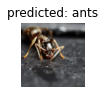

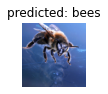

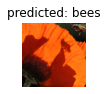

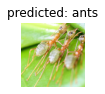

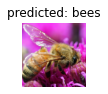

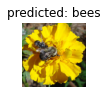

In [18]:
visualize_model(model_conv)

plt.ioff()
plt.show()

Further Learning
-----------------

If you would like to learn more about the applications of transfer learning,
checkout our `Quantized Transfer Learning for Computer Vision Tutorial <https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html>`_.



